# Conditional Edge

This example was created based on the guide available at [this link](https://langchain-ai.github.io/langgraph/how-tos/branching/) to explore conditional edges in langgraph. 

For the required dependencies, we refer to LangChain's tutorial page without providing a separate explanation.

Additionally, you need to install the following module:
```bash
pip install crimson-langgraph-dev-tool
```

## Basic

The example available at [this link](https://langchain-ai.github.io/langgraph/how-tos/branching/#conditional-branching) is applied as is.

However, I wasn't entirely satisfied with the structure of the `route_bc_or_cd` function, so I replaced it with the `route_chars` function.

In [1]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_node(e)
builder.add_edge(START, "a")


def route_chars(state: State) -> Sequence[str]:
    return list(state["which"])

intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_chars,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")

builder.add_edge("e", END)
graph = builder.compile()

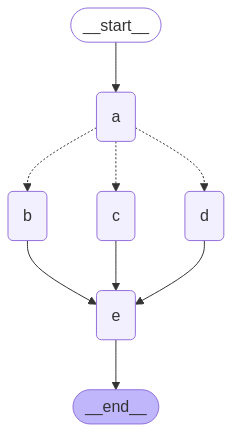

In [2]:
from crimson.langgraph_dev_tool.display import display_graph

display_graph(graph)

In [3]:
graph.invoke({"aggregate": [], "which": "bcd"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'B', 'C', 'D']


{'aggregate': ['A', 'B', 'C', 'D', 'E'], 'which': 'bcd'}

## Extended Example Based on Type Hints

The signature of `add_conditional_edges` is as follows.\
In the official examples, only cases using `Callable` and `List` were found, so I have created a simple example where a `Runnable` is used for `path` and a dictionary is used for `path_map`.

```python
    def add_conditional_edges(
        self,
        source: str,
        path: Union[
            Callable[..., Union[Hashable, list[Hashable]]],
            Callable[..., Awaitable[Union[Hashable, list[Hashable]]]],
            Runnable[Any, Union[Hashable, list[Hashable]]],
        ],
        path_map: Optional[Union[dict[Hashable, str], list[str]]] = None,
        then: Optional[str] = None,
    ) -> Self:
```

In [4]:
from langchain_core.runnables import RunnableLambda
from typing import Annotated
import operator
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    value: int

def increment(state: State) -> State:
    return {"value": state["value"] + 1}

def even_node(state: State) -> State:
    print("Even node triggered")
    return {"value": state["value"] * 10}

def odd_node(state: State) -> State:
    print("Odd node triggered")
    return {"value": state["value"] * -1}

# Normal callable function
def check_even_odd(state: State) -> str:
    return "even" if state["value"] % 2 == 0 else "odd"

# Wrap check_even_odd with RunnableLambda
runnable_even_odd = RunnableLambda(check_even_odd)

builder = StateGraph(State)
builder.add_node(increment)
builder.add_node(even_node)
builder.add_node(odd_node)
builder.add_edge(START, "increment")

# Use runnable_even_odd as the path, and use a dictionary for path_map
builder.add_conditional_edges(
    "increment",
    runnable_even_odd,  # Conditional branching function in Runnable form
    path_map={"even": "even_node", "odd": "odd_node"}
)

builder.add_edge("even_node", END)
builder.add_edge("odd_node", END)

graph = builder.compile()

print("Invoke with value 1:")
result1 = graph.invoke({"value": 1})
print(result1)

print("Invoke with value 2:")
result2 = graph.invoke({"value": 2})
print(result2)


Invoke with value 1:
Even node triggered
{'value': 20}
Invoke with value 2:
Odd node triggered
{'value': -3}


## Why Runnable instead of Callable?

We create an example to demonstrate the additional functionality that can be achieved by using Runnable.

In [5]:
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, START, END
from langsmith import RunTree

# Define state
class State(TypedDict):
    value: int

# Node: Increments the value by 1.
def increment(state: State) -> State:
    return {"value": state["value"] + 1}

# Node: Executed when the value is even.
def even_node(state: State) -> State:
    print("Even node triggered")
    return {"value": state["value"] * 10}

# Node: Executed when the value is odd.
def odd_node(state: State) -> State:
    print("Odd node triggered")
    return {"value": state["value"] * -1}

# Branch decision function: Returns "even" if the value is even, "odd" if it is odd.
def check_even_odd(state: State) -> str:
    return "even" if state["value"] % 2 == 0 else "odd"

# Callback functions to be invoked before and after execution (used with with_listeners)
def on_start_callback(run_obj: RunTree):
    # run_obj contains various information about the execution.
    print("[Listener] Execution started.")

def on_end_callback(run_obj: RunTree):
    print("[Listener] Execution ended. Output:", run_obj.outputs)

# Wrap the check_even_odd function with RunnableLambda, then add callbacks using with_listeners.
runnable_even_odd = RunnableLambda(check_even_odd).with_listeners(
    on_start=on_start_callback,
    on_end=on_end_callback
)

# Build the graph.
builder = StateGraph(State)
builder.add_node(increment)
builder.add_node(even_node)
builder.add_node(odd_node)
builder.add_edge(START, "increment")

# After executing the 'increment' node, branch using runnable_even_odd: map the returned value to a node name using path_map.
builder.add_conditional_edges(
    "increment",
    runnable_even_odd,
    path_map={"even": "even_node", "odd": "odd_node"}
)

builder.add_edge("even_node", END)
builder.add_edge("odd_node", END)

graph = builder.compile()

print("Invoke with value 1:")
result1 = graph.invoke({"value": 1})
print("Result:", result1)

print("\nInvoke with value 2:")
result2 = graph.invoke({"value": 2})
print("Result:", result2)



Invoke with value 1:
[Listener] Execution started.
[Listener] Execution ended. Output: {'output': 'even'}
Even node triggered
Result: {'value': 20}

Invoke with value 2:
[Listener] Execution started.
[Listener] Execution ended. Output: {'output': 'odd'}
Odd node triggered
Result: {'value': -3}


### Further Typehint

The signature of the `with_listeners` function is as follows:

```python
def with_listeners(
	self,
	*,
	on_start: Optional[
		Union[Callable[[Run], None], Callable[[Run, RunnableConfig], None]]
	] = None,
	on_end: Optional[
		Union[Callable[[Run], None], Callable[[Run, RunnableConfig], None]]
	] = None,
	on_error: Optional[
		Union[Callable[[Run], None], Callable[[Run, RunnableConfig], None]]
	] = None,
) -> Runnable[Input, Output]:
```

When debugging the `on_end_callback` function, I discovered that `run_obj` is an instance of the `RunTree` class.\
To typehint this, I traced where that class is located using the code below.

In [6]:
# pip install crimson-folder-system-beta

from crimson.folder_system_beta.search import filter_files_by_content
from crimson.folder_system_beta.filter import ReFilter

filter_files_by_content(
	base_root="/home/crimson/miniconda3/envs/langgraph-dev-tool/lib/python3.12/site-packages/langchain_core",
    path_filter=ReFilter(exclude=['egg-info']),
	content_filter=ReFilter(include=['RunTree'])
)

['/home/crimson/miniconda3/envs/langgraph-dev-tool/lib/python3.12/site-packages/langchain_core/tracers/schemas.py']